pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


Using TensorFlow backend.
/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 1,685,154
Trainable params: 1,685,154
Non-trainable params: 0
_________________________________________________________________


/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


iteration: 19999 elapsed time: 2035.2499158382416 epsilon: 0.0001 action: [0. 1.] random: False reward: 0.1 Q max: 1.3478864                                     Q max: 0.071042195                    0.062403675                    0.08312604630231513 action: [0. 1.] random: False reward: 0.1 Q max: 0.4781657                     0.1 Q max: 0.54507643                    0.0676557577878894 action: [1. 0.] random: False reward: 0.1 Q max: 0.62573063                     [1. 0.] random: False reward: 0.1 Q max: 0.8952747                    epsilon: 0.057790139506975355 action: [1. 0.] random: False reward: 0.1 Q max: 0.6566726                    [1. 0.] random: True reward: 0.1 Q max: 1.0118673                    False reward: 0.1 Q max: 0.62232405                     [1. 0.] random: False reward: 0.1 Q max: 0.6205803                     0.1 Q max: 0.90935063                    reward: 0.1 Q max: 0.9425973                     [1. 0.] random: False reward: 0.1 Q max: 0.6596676                 

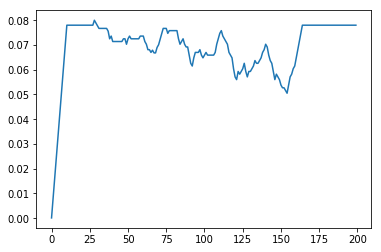

In [1]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()


%matplotlib inline
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from game.flappy_bird import GameState
import os
import sys
import matplotlib.pyplot as plt




# TODO deactivate pygame window
# TODO compute running mean

from keras import models, layers, optimizers, initializers

class Agent:
    
    def __init__(self):
        self.number_of_actions = 2
        self.gamma = 0.99
        self.final_epsilon = 0.0001
        self.initial_epsilon = 0.1
        self.number_of_iterations = 20000 #2000000
        self.replay_memory_size = 10000
        self.minibatch_size = 32

        self.model = self.create_model()
    
    def create_model(self):
        kernel_initializer = initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None)
        bias_initializer = initializers.Constant(value=0.01)
        
        model = models.Sequential()
        model.add(layers.Conv2D(32, (8, 8), strides=(4, 4), activation="relu", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, input_shape=(84, 84, 4)))
        model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), activation="relu", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))
        model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), activation="relu", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation="relu", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))
        model.add(layers.Dense(self.number_of_actions, activation="linear", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))
        model.compile(
            optimizer=optimizers.Adam(lr=1e-6),
            loss="mse"
        )
        return model
    
Agent().model.summary()

def resize_and_bgr2gray(image):
    image = image[0:288, 0:404]
    image = color.rgb2gray(image)
    image = resize(image, (84, 84), anti_aliasing=True)
    image = np.reshape(image, (84, 84, 1))
    image[image > 0] = 255
    image = image.transpose(2, 0, 1)
    image = image.astype(np.float32) / 255.0 # TODO division right?
    return image

def render_state(state):
    for i in range(state.shape[-1]):
        image_data = state[0,:,:, i]
        print(image_data.shape)
        plt.subplot(1, state.shape[-1], i + 1)
        plt.imshow(image_data, cmap="gray")
        
    plt.show()
    plt.close()


def train(agent, start_time):

    # instantiate game
    game_state = GameState()

    # initialize replay memory
    replay_memory = []

    # initial action is do nothing
    action = np.zeros((agent.number_of_actions,)).astype("float32")
    action[0] = 1.0

    # Initialize state.
    image_data, reward, terminal = game_state.frame_step(action)
    image_data = resize_and_bgr2gray(image_data)
    state = np.zeros((84, 84, 4))
    state[:,:,0] = image_data
    state[:,:,1] = image_data
    state[:,:,2] = image_data
    state[:,:,3] = image_data
    
    # Initialize running means.
    running_mean_length = 1000
    running_mean_frequency = 100
    rewards_array = np.zeros((running_mean_length, ))
    running_means = []
    
    # initialize epsilon value
    epsilon = agent.initial_epsilon
    iteration = 0
    epsilon_decrements = np.linspace(agent.initial_epsilon, agent.final_epsilon, agent.number_of_iterations)

    # main infinite loop
    for iteration in range(agent.number_of_iterations):
        
        # Get an action. Either random or predicted. This is epsilon greedy exploration.
        epsilon = epsilon_decrements[iteration]
        action = np.zeros((agent.number_of_actions,)).astype("float32")
        do_random_action = random.random() <= epsilon
        output = agent.model.predict(np.expand_dims(state, axis=0))[0]
        if do_random_action:
            action_index = random.randint(0, agent.number_of_actions - 1)
        else:
            action_index = np.argmax(output)
        action[action_index] = 1.0 
        
        # Get next state and reward
        image_data_next, reward, terminal = game_state.frame_step(action)
        image_data_next = resize_and_bgr2gray(image_data_next)
        
        #state_1 = torch.cat((state.squeeze(0)[1:, :, :], image_data_1)).unsqueeze(0)
        state_next = np.zeros((84, 84, 4))
        state_next[:,:,0] = state[:,:,1]
        state_next[:,:,1] = state[:,:,2]
        state_next[:,:,2] = state[:,:,3]
        state_next[:,:,3] = image_data_next
        #render_state(state_1)
        
        #action = action.unsqueeze(0)
        #reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0)

        # Save transition to replay memory and ensure length.
        replay_memory.append((state, action, reward, state_next, terminal))
        if len(replay_memory) > agent.replay_memory_size:
            replay_memory.pop(0)

        #print("replay_memory", len(replay_memory))
            
        # sample random minibatch
        minibatch = random.sample(replay_memory, min(len(replay_memory), agent.minibatch_size))
        
        # unpack minibatch
        state_batch = np.array([d[0] for d in minibatch])
        action_batch = np.array([d[1] for d in minibatch])
        reward_batch = np.array([d[2] for d in minibatch])
        state_next_batch = np.array([d[3] for d in minibatch])
        terminal_batch = np.array([d[4] for d in minibatch])
        
        # Do gradient descent.
        targets = agent.model.predict(state_batch)
        Q_sa = agent.model.predict(state_next_batch)
        targets[:, np.argmax(action_batch, axis=1)] = reward_batch + agent.gamma * np.max(Q_sa, axis=1) * np.invert(terminal_batch)
        agent.model.train_on_batch(state_batch, targets)

        rewards_array[iteration % running_mean_length] = reward
        if iteration % running_mean_frequency == 0:
            running_means.append(np.mean(rewards_array))
        
        # set state to be state_1
        state = state_next

        #if iteration % 25000 == 0:
        #    torch.save(model, "pretrained_model/current_model_" + str(iteration) + ".pth")

        print("iteration:", iteration, "elapsed time:", time.time() - start_time, "epsilon:", epsilon, "action:",
              action, "random:", do_random_action, "reward:", reward, "Q max:",
              np.max(output), "                   ", end="\r")

    print("")
    print(len(running_means))
    plt.plot(running_means)
    plt.show()
    plt.close()
 
agent = Agent()
start_time = time.time()
train(agent, start_time)

vdisplay.stop()

In [ ]:
     
def test(model):
    game_state = GameState()

    # initial action is do nothing
    action = torch.zeros([model.number_of_actions], dtype=torch.float32)
    action[0] = 1.0
    image_data, reward, terminal = game_state.frame_step(action)
    image_data = resize_and_bgr2gray(image_data)
    state = torch.cat((image_data, image_data, image_data, image_data)).unsqueeze(0)

    while True:
        # get output from the neural network
        output = model(state)[0]

        action = torch.zeros([model.number_of_actions], dtype=torch.float32)
        if torch.cuda.is_available():  # put on GPU if CUDA is available
            action = action.cuda()

        # get action
        action_index = torch.argmax(output)
        if torch.cuda.is_available():  # put on GPU if CUDA is available
            action_index = action_index.cuda()
        action[action_index] = 1

        # get next state
        image_data_1, reward, terminal = game_state.frame_step(action)
        image_data_1 = resize_and_bgr2gray(image_data_1)
        state_1 = torch.cat((state.squeeze(0)[1:, :, :], image_data_1)).unsqueeze(0)

        # set state to be state_1
        state = state_1


def main(mode):
    if mode == 'test':
        raise Exception("Implement!")
        #if torch.cuda.is_available():
        #    model = torch.load('pretrained_model/current_model_2000000.pth').eval()
        #else:
        #    model = torch.load('pretrained_model/current_model_2000000.pth', map_location='cpu').eval()
        #if torch.cuda.is_available():  # put on GPU if CUDA is available
        #    model = model.cuda()
        #test(model)
    elif mode == 'train':
        if not os.path.exists('pretrained_model/'):
            os.mkdir('pretrained_model/')
        agent = Agent()
        start_time = time.time()
        train(agent, start_time)


main("train")

In [ ]:
import pygame
pygame.quit()